In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [238]:
def parse_contribution_tree(scenario):
    # Read the Excel file into a DataFrame
    df = pd.read_excel('contribution_tree.xlsx', 'Upstream tree')

    # Get the impact category and unit as the dataset name
    labels = df.columns[0].split(':')
    category = ','.join(labels[1:])[1:]
    unit = df.iloc[0][8]
    unit = unit[unit.find('[')+1:unit.find(']')]
    unit = ''.join(['[', unit, ']'])
    name = ''.join([category, ' ', unit])

    # Initialize variables
    processes = []
    final_rows = []
    current_subprocess_level = -1

    # Iterate through the rows of the dataframe
    for i, row in df.iterrows():
        # Replace nan by 0 in 'Direct contributions [CTUe]' column
        if pd.isna(row.iloc[-1]):
            row.iloc[-1] = 0

        # Determine level by checking which cell is filled in the row
        level = next((j for j in range(len(row)) if not pd.isna(row[j])), len(row))
        if level == current_subprocess_level:
            current_subprocess_level -= 1

        # Check if the current row is a subprocess
        if row[level].startswith(scenario):
            current_subprocess_level = level
            row['Level'] = level
            final_rows.append(row.dropna().values)
            processes.append([row.dropna().values])

        # Check if the row is an activity and needs to be retained
        elif not pd.isna(row[level]):
            # Check if the activity is directly under a subprocess
            if level - 1 == current_subprocess_level:
                # Direct child of a subprocess
                row['Level'] = level
                final_rows.append(row.dropna().values)

    # Create a new DataFrame from the filtered rows
    final_rows[0][-1] = 'Level'
    final_df = pd.DataFrame(final_rows)
    final_df.columns = final_df.iloc[0]
    final_df = final_df[1:]

    # Group subprocesses
    for i, row in final_df.iterrows():
        for j, p in enumerate(processes):
            if row['Level'] - 1 == p[0][-1]:
                p.append(row.values)

    final_processes = []
    for i, p in enumerate(processes):
        final_processes.append(pd.DataFrame(list(map(np.ravel, p)), columns=final_df.columns))
    
    return name, final_df, final_processes

In [349]:
category, contributions, processes = parse_contribution_tree('Baseline')

c:\ProgramData\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [262]:
category

'Human toxicity, carcinogenic, inorganics [CTUh]'

In [350]:
processes[0]

,Processes,Result [CTUh],Direct contribution [CTUh],Level
0,"Baseline - 7 Effluent treatment, substitution ...",-8.985897e-06,0.000000e+00,0
1,"market for hazardous waste, for underground de...",2.368781e-08,0.000000e+00,1
2,"market group for electricity, medium voltage |...",1.849581e-08,0.000000e+00,1
3,"market for wastewater, average | wastewater, a...",1.199468e-09,3.737418e-11,1
4,"market for quicklime, milled, packed | quickli...",9.353848e-10,0.000000e+00,1
5,market group for tap water | tap water | Cutof...,3.306377e-10,0.000000e+00,1
6,"market for wastewater, unpolluted | wastewater...",2.983697e-10,0.000000e+00,1
7,"Baseline - 6 Li recovery, substitution - RER",-9.030844e-06,0.000000e+00,1


In [351]:
sub_process_names = [
    'Leaching',
    'Solution purification',
    'Mn recovery',
    'Co recovery',
    'Ni recovery',
    'Li recovery',
    'Effluent treatment'
]
sub_processes = []

# Extract the subprocess 'totals' into a separate list. Keep only upstream
# processes in the list
for p in processes:
    for i, row in p.iterrows():
        if row[0].startswith('Baseline'):
            sub_processes.append(row)
            p.drop(index=i, inplace=True)

In [352]:
sub_processes

[0
 Processes                     Baseline - 7 Effluent treatment, substitution ...
 Result [CTUh]                                                         -0.000009
 Direct contribution [CTUh]                                                  0.0
 Level                                                                         0
 Name: 0, dtype: object,
 0
 Processes                     Baseline - 6 Li recovery, substitution - RER
 Result [CTUh]                                                    -0.000009
 Direct contribution [CTUh]                                             0.0
 Level                                                                    1
 Name: 7, dtype: object,
 0
 Processes                     Baseline - 6 Li recovery, substitution - RER
 Result [CTUh]                                                    -0.000009
 Direct contribution [CTUh]                                               0
 Level                                                                    1
 Name: 0,

In [353]:
used = set()
sub_processes = [used.add(tuple(sp[0])) or sp for sp in sub_processes if tuple(sp[0]) not in used]

In [328]:
for sp in sub_processes:
    print(sp[0])

Baseline - 7 Effluent treatment, substitution - RER
Baseline - 6 Li recovery, substitution - RER
Baseline - 5 Ni recovery, substitution - RER
Baseline - 4 Co recovery, substitution - RER
Baseline - 3 Mn recovery, substitution - RER
Baseline - 2 Solution purification, substitution - RER
Baseline - 1 Leaching, substitution - RER


In [362]:
for p in processes:
    for i, row in p.iterrows():
        split_row = row[0].split(' | ')
        p.loc[i, 'Processes'] = split_row[0]
        if row[0].startswith('market for'):
            p.loc[i, 'Processes'] = row[0][11:]
        if row[0].startswith('market group for'):
            p.loc[i, 'Processes'] = row[0][17:]

# for p in processes:
#     for i, row in p.iterrows():
#         print(row[0])

In [366]:
processes[3]

,Processes,Result [CTUh],Direct contribution [CTUh],Level
2,"hazardous waste, for incineration",5.819872e-08,0,4
3,"sodium hydroxide, without water, in 50% soluti...",2.002328e-08,0,4
4,Cyanex 272 production,1.401727e-08,0,4
5,"electricity, medium voltage",7.187823e-09,0,4
6,sulfuric acid,6.390661e-09,0,4
7,kerosene,2.658210e-09,0,4
8,"steam, in chemical industry",2.381464e-09,0,4
9,tap water,1.799891e-10,0,4
10,cobalt sulfate,-2.575607e-06,0,4


In [372]:
for i, p in enumerate(processes):
    p['Sub-process'] = sub_process_names[6-i]

In [373]:
combined_df = pd.concat(processes)
combined_df

,Processes,Result [CTUh],Direct contribution [CTUh],Level,Sub-process
1,"hazardous waste, for underground deposit",2.368781e-08,0.000000e+00,1,Effluent treatment
2,"electricity, medium voltage",1.849581e-08,0.000000e+00,1,Effluent treatment
3,"wastewater, average",1.199468e-09,3.737418e-11,1,Effluent treatment
4,"quicklime, milled, packed",9.353848e-10,0.000000e+00,1,Effluent treatment
5,tap water,3.306377e-10,0.000000e+00,1,Effluent treatment
6,"wastewater, unpolluted",2.983697e-10,0.000000e+00,1,Effluent treatment
1,"soda ash, dense",2.017052e-07,0.000000e+00,2,Li recovery
2,"electricity, medium voltage",1.979989e-08,0.000000e+00,2,Li recovery
3,tap water,4.022080e-10,0.000000e+00,2,Li recovery
4,"sodium sulfate, anhydrite",-1.826448e-07,0.000000e+00,2,Li recovery


In [376]:
pivot_df = combined_df.pivot(index='Sub-process', columns='Processes', values=combined_df.columns[1]).fillna(0)

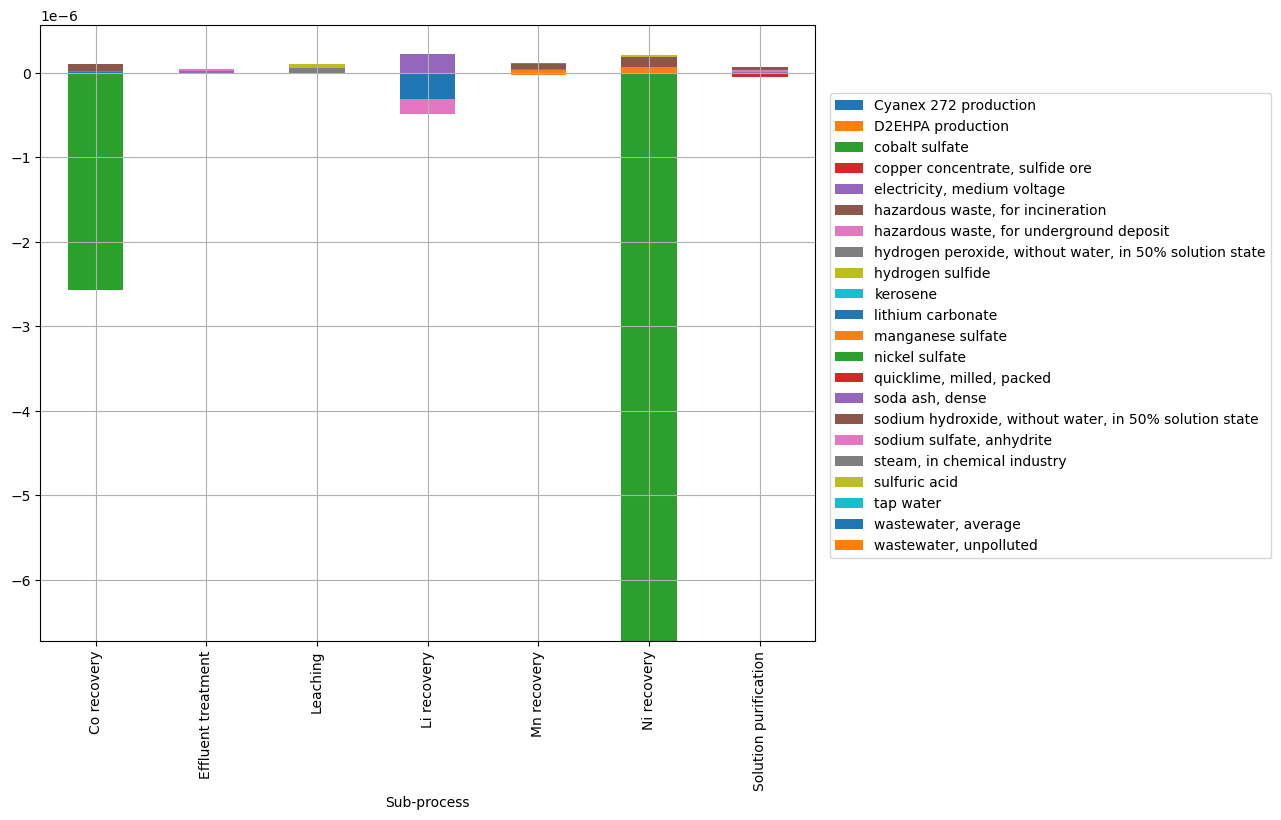

In [377]:
fig, ax = plt.subplots(figsize=(10, 8))

pivot_df.plot.bar(stacked=True, grid=True, ax=ax)
plt.legend(bbox_to_anchor=(1.01, 0.9))

plt.show()